# 1. Kamlan_Filter Class

In [1]:
def Kalman_Filter(Y):
    S = Y.shape[0]
    S = S + 1
    "Initialize Params:"
    Z = param0[0]
    T = param0[1]
    H = param0[2]
    Q = param0[3]
    # "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    KF_Dens = np.zeros(S)
    for s in range(1,S):
        if s == 1: 
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
        else: 
            F[s]= Z*P_predict[s-1]*np.transpose(Z)+H
            v[s] = Y[s-1] - Z*u_predict[s-1]
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_predict[s];
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q
            Likelihood = np.sum(KF_Dens[1:-1])  
            return Likelihood

In [2]:
def Kalman_Smoother(params, Y):
    S = Y.shape[0]
    S = S + 1
    "Initialize Params:"
    Z = params[0]
    T = params[1]
    H = params[2]
    Q = params[3]
    "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    for s in range(1,S):
        if s == 1: 
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
        else: 
            # "Please fill this part."
            F[s]= Z*P_predict[s-1]*np.transpose(Z)+H
            v[s] = Y[s-1] - Z*u_predict[s-1]
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_predict[s];
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    
    
            u_smooth = np.zeros(S)
            P_smooth = np.zeros(S)
            u_smooth[S-1] = u_update[S-1]
            P_smooth[S-1] = P_update[S-1]    
    for  t in range(S-1,0,-1):
     
        u_smooth[t-1] = u_update[t] +P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]- T*u_update[t])
        P_smooth[t-1] = P_update[t] + (P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_update[t])/P_update[t]*T*P_update[t])
    
    u_smooth = u_smooth[0:-1]
    return u_smooth

# 2. Implementing the Kalman Model on random data 

In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from math import sqrt

import datetime
import pandas_datareader as web

In [4]:
# amzn = pd.read_csv("AMZN.csv")
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2020, 1, 1)
df_amzn = web.DataReader('AMZN', 'yahoo', start, end) 
amzn= df_amzn
amzn=amzn.reset_index()
amzn['Date'] = pd.to_datetime(amzn['Date'])
amzn['Typical_Price'] = amzn[['High','Low','Close']].mean(axis=1)
amzn['lrets'] = (np.log(amzn.Close) - np.log(amzn.Close.shift(1))) * 100.
amzn.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Typical_Price,lrets
0,2014-01-02,399.359985,394.019989,398.799988,397.970001,2137800,397.970001,397.116659,NaN
1,2014-01-03,402.709991,396.220001,398.290009,396.440002,2210200,396.440002,398.456665,-0.385192
2,2014-01-06,397.000000,388.420013,395.850006,393.630005,3170600,393.630005,393.016673,-0.711332
3,2014-01-07,398.470001,394.290009,395.040009,398.029999,1916000,398.029999,396.930003,1.111598
4,2014-01-08,403.000000,396.040009,398.470001,401.920013,2316500,401.920013,400.320007,0.972572


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 6
         Gradient evaluations: 1


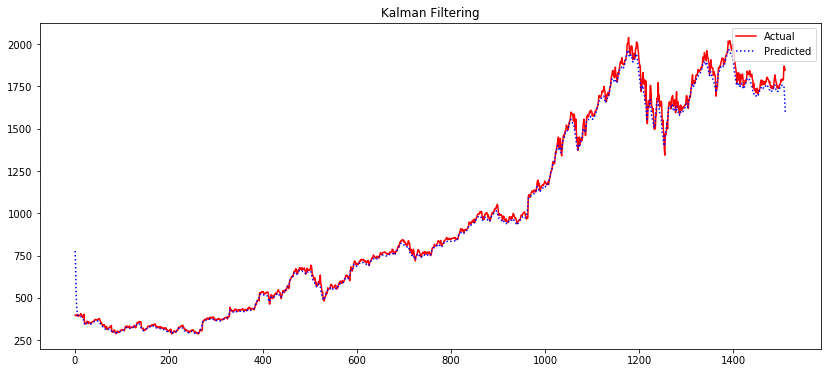

In [5]:
Y = amzn['Close']
T = Y.shape[0]
mu = 1196;


param0 = np.array([0.3, 0.9, 0.8, 1.1])
param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
y_pred = Kalman_Smoother(param_star.x, Y)

timevec = np.linspace(1,T,T)


fig= plt.figure(figsize=(14,6))
plt.plot(timevec, Y,'r-', label='Actual')
plt.plot(timevec, y_pred,'b:', label='Predicted')
plt.legend(loc='upper right')
plt.title("Kalman Filtering")
plt.show()

In [6]:
results = pd.DataFrame({'Actual': list(Y),
                  'Predicted' : list(y_pred),
                  'Date':amzn['Date'],
                  'Open':amzn['Open'],
                  'Close':amzn['Close']
                       })


In [7]:
results.set_index('Date',inplace = True)
results.head(10)

,Actual,Predicted,Open,Close
Date,,,,
2014-01-02,397.970001,777.276970,398.799988,397.970001
2014-01-03,396.440002,700.499279,398.290009,396.440002
2014-01-06,393.630005,546.121895,395.850006,393.630005
2014-01-07,398.029999,467.370682,395.040009,398.029999
2014-01-08,401.920013,427.745356,398.470001,401.920013
2014-01-09,401.010010,407.208938,403.709991,401.010010
2014-01-10,397.660004,396.624085,402.529999,397.660004
2014-01-13,390.980011,391.668170,397.980011,390.980011
2014-01-14,397.540009,391.673994,392.130005,397.540009


# 3.1 Long Short Day trading:
* if predicted > yesterdays close, buy and sell at end of day

* if predicted < yesterdays close, sell and buy at end of day

In [8]:
amount = 10000
signal = 0
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []

for i in range(len(results)-1):
    if results['Predicted'][i] > results['Actual'][i-1]:
        action.append('Buy at Open & Sell at Close')
        stocks = int(amount/results['Open'][i])
        balance = int(amount%results['Close'][i])
        portfolio = stocks * results ['Open'][i]
        print(i,'Buy at Open',round(portfolio,2),stocks,round(balance,2))
        
        
        # action.append('Sell at End')
        portfolio = stocks * results['Close'][i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i,'Sell at Close',round(amount,2),balance)
        Amount.append(amount)
        # add by Hongbo
        Portfolio.append(round(portfolio,5))
        
    else:
        action.append('Sell at Open & Bull at Close')
        stocks = int(amount/results['Open'][i])
        balance = int(amount%results['Close'][i])
        portfolio = stocks * results ['Open'][i]
        print(i,'Sell at Open',round(portfolio,2),'-',stocks,round(balance,2))
        
        
        # action.append('Buy at Close')
        portfolio = stocks * results['Close'][i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i,'Buy Back at Close',round(amount,2),balance)
        Amount.append(amount)
        # add by Hongbo
        Portfolio.append(round(portfolio,5))
    print('\n')
        

Buy Back at Close 3921.6 0


1211 Sell at Open 3484.48 - 2 384
1211 Buy Back at Close 3921.4 0


1212 Sell at Open 3547.4 - 2 593
1212 Buy Back at Close 3921.4 0


1213 Sell at Open 3406.68 - 2 357
1213 Buy Back at Close 3921.34 0


1214 Sell at Open 3299.18 - 2 635
1214 Buy Back at Close 3920.62 0


1215 Sell at Open 3320.0 - 2 842
1215 Buy Back at Close 3919.76 0


1216 Buy at Open 2972.32 2 858
1216 Sell at Close 3918.84 0


1217 Buy at Open 3139.98 2 722
1217 Sell at Close 3918.02 0


1218 Buy at Open 3247.06 2 586
1218 Sell at Close 3917.06 0


1219 Sell at Open 3357.18 - 2 586
1219 Buy Back at Close 3917.06 0


1220 Sell at Open 3315.14 - 2 661
1220 Buy Back at Close 3916.6 0


1221 Buy at Open 3236.7 2 630
1221 Sell at Close 3915.62 0


1222 Buy at Open 3346.0 2 404
1222 Sell at Close 3914.98 0


1223 Sell at Open 3510.0 - 2 405
1223 Buy Back at Close 3914.82 0


1224 Sell at Open 3465.0 - 2 489
1224 Buy Back at Close 3913.86 0


1225 Sell at Open 3396.48 - 2 640
1225 Buy Back a

In [9]:
# Strategy_Result = pd.DataFrame({'Actual_Close_Price':amzn.Close[1:],
#                                  'Predicted_Close_Price':list(y_pred[1:]),
#                                  'Date': amzn.Date[1:],
#                                  'Action':  action,
#                                  'Stocks': Stocks,
#                                  'Portfolio($)': Portfolio,
#                                  'Amount($)':Amount
#                                     })

# Strategy_Result.head()

Strategy_Result = pd.DataFrame({'Actual_Close_Price':amzn.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': amzn.Date[1:],
                                 'Action':  action,
                                 # 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Portfolio($),Amount($)
1,396.440002,700.499279,2014-01-03,Sell at Open & Bull at Close,0,9999.250031
2,393.630005,546.121895,2014-01-06,Buy at Open & Sell at Close,0,9999.000061
3,398.029999,467.370682,2014-01-07,Buy at Open & Sell at Close,0,9998.750122
4,401.920013,427.745356,2014-01-08,Buy at Open & Sell at Close,0,9998.749969
5,401.010010,407.208938,2014-01-09,Buy at Open & Sell at Close,0,10400.000336


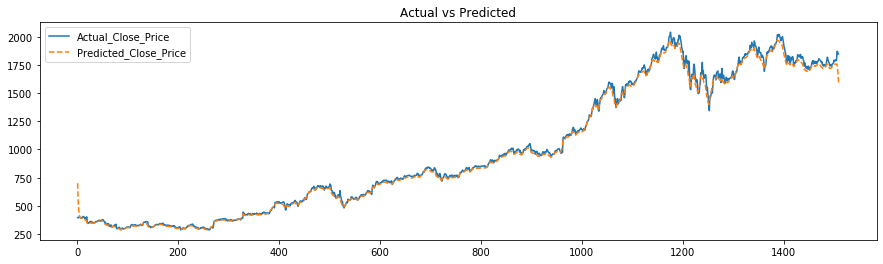

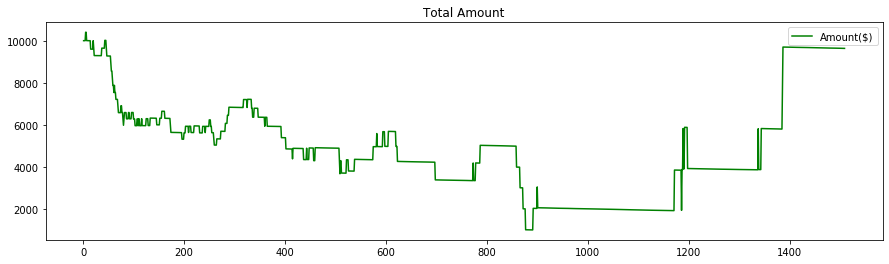

In [10]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-g'], 
                                            title = 'Total Amount')

In [11]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')

Initial_Investment : 10000$
Final Amount: 9633.450073242188 $
Profit_Percent: 96.33450073242187 %


* Sharpe Ratio

In [12]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()


In [13]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
print(mean_returns,sd)
Market_RF = 0.0464


Sharpe_Ratio = np.sqrt(877)*(mean_returns)/sd
Sharpe_Ratio

0.0017630673637927632 0.06551641015591861


0.7969271263069906

# 3.2 Buy & Hold Trading Strategy
 
* Position trading 
* Buy if we have next days predicted_value greater than todays close value and hold if already bought 
* Sell if we have next days predicted_value lesser than todays close value and dont buy until rule 1

In [14]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(results)-1):
    if results['Predicted'][i+1] > results['Actual'][i]:
        if signal == 0:
            action.append('Buy')
            stocks = int(amount / results['Actual'][i])
            balance = int(amount % results['Actual'][i])
            portfolio = stocks * results['Actual'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:',results['Actual'][i] ,'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Bought--Holding')
            portfolio = stocks * results['Actual'][i]
            amount = portfolio + balance
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    elif results['Predicted'][i+1] < results['Actual'][i]:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * results['Actual'][i]
            
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Price-Prediction-Already-Lower')
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    print('\n')
    

tal($) 1490375.64


Stock: 1899.8699951171875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 1490375.64


Stock: 1889.97998046875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 1490375.64


Stock: 1822.6800537109375 Action: Buy Portfolio: 1489129.6 Stocks: 817 Balance_init: 1246 total($) 1490375.6


Stock: 1840.1199951171875 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 1504624.04


Stock: 1871.1500244140625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 1504624.04


Stock: 1907.5699462890625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 1504624.04


Stock: 1869.0 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 1504624.04


Stock: 1858.969970703125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 1504624.04


Stock: 1857.52001953125 Acti

In [15]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':amzn.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': amzn.Date[1:],
                                 'Action':  action,
                                 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Stocks,Portfolio($),Amount($)
1,396.440002,700.499279,2014-01-03,Buy,25,9949.25003,9999.0
2,393.630005,546.121895,2014-01-06,Bought--Holding,25,9911.00006,9961.0
3,398.029999,467.370682,2014-01-07,Bought--Holding,25,9840.75012,9891.0
4,401.920013,427.745356,2014-01-08,Bought--Holding,25,9950.74997,10001.0
5,401.010010,407.208938,2014-01-09,Bought--Holding,25,10048.00034,10098.0


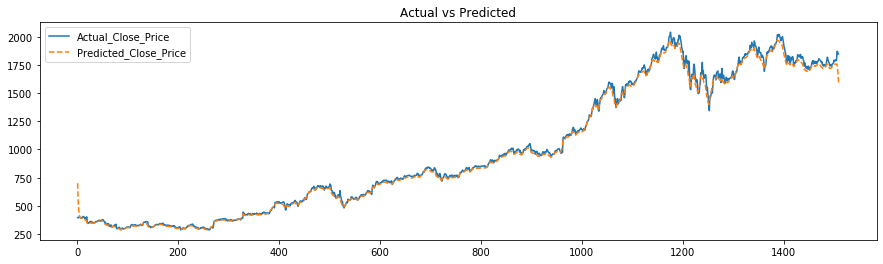

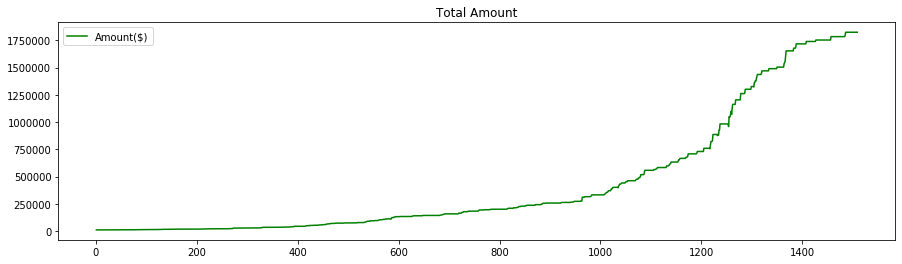

In [16]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-g'], 
                                            title = 'Total Amount')

In [17]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')

Initial_Investment : 10000$
Final Amount: 1824707.0 $
Profit_Percent: 18247.07 %


* Sharpe Ratio

In [18]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()


In [19]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
print(mean_returns,sd)
Market_RF = 0.0464


Sharpe_Ratio = np.sqrt(877)*(mean_returns)/sd
Sharpe_Ratio

0.0035218274171084554 0.011488478368738807


9.078317258627468

# 3.3 Buy & Hold Trading Strategy with bolling bands

In [20]:
long_MA = results['Actual'].rolling(window=20).mean()
results['Long_Moving_Avg'] = long_MA

In [21]:
short_MA  = results['Actual'].rolling(window=5).mean()
results['Short_Moving_Avg'] = short_MA 

In [22]:
long_std= results['Actual'].rolling(window=20).std()
results['Long_std'] = long_std

In [23]:

long_upper_band = ((long_MA) + (long_std)*0.75)
results['Long_Upper_Band'] = long_upper_band

In [24]:
long_lower_band = ((long_MA) - (long_std)*0.75)
results['Long_Lower_Band'] = long_lower_band

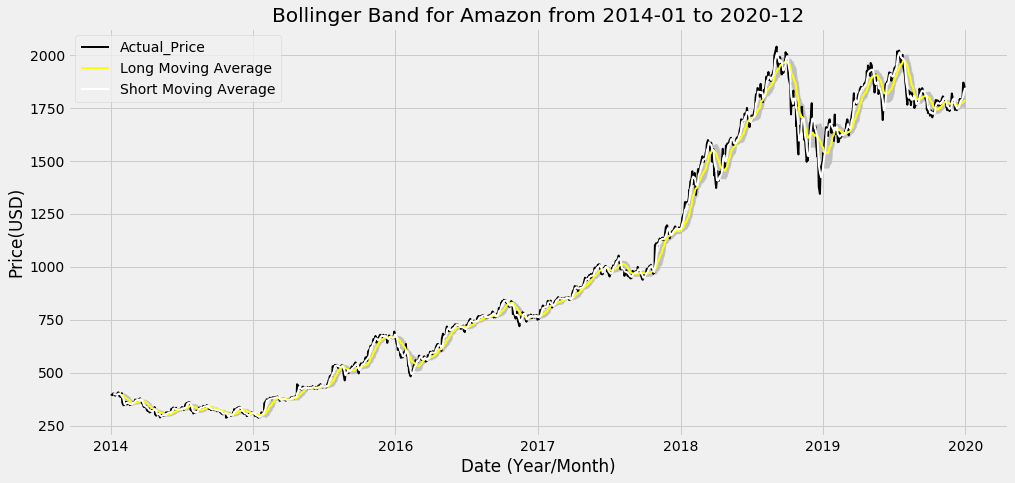

In [25]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
x_axis = results.index
ax.fill_between(x_axis, results['Long_Upper_Band'], results['Long_Lower_Band'], color='silver')
ax.plot(x_axis, results['Actual'], color='black', lw=2, label = 'Actual_Price')
ax.plot(x_axis, results['Long_Moving_Avg'], color='yellow', lw=2, label = 'Long Moving Average')
ax.plot(x_axis, results['Short_Moving_Avg'], color='white', lw=2, label = 'Short Moving Average')

ax.set_title('Bollinger Band for Amazon from 2014-01 to 2020-12')
ax.set_xlabel('Date (Year/Month)')
ax.set_ylabel('Price(USD)')
ax.legend()
plt.show()

In [232]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(results)-1):
    if results['Predicted'][i] > results['Long_Lower_Band'][i]:
        if signal == 0:
            
            action.append('Buy')
            stocks = int(amount / results['Actual'][i])
            balance = int(amount % results['Actual'][i])
            portfolio = stocks * results['Actual'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:',results['Actual'][i] ,'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Bought--Holding')
            portfolio = stocks * results['Actual'][i]
            amount = portfolio + balance
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    elif results['Predicted'][i] < results['Long_Moving_Avg'][i]:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * results['Actual'][i]
            
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Price-Prediction-Already-Lower')
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
    else:
        action.append('Do nothing')
        print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
        Portfolio.append(round(portfolio,5))
        Amount.append(round(amount,0))
        Stocks.append(stocks)

            
    print('\n')
    

3.74


Stock: 1926.52001953125 Action: Bought--Holding Portfolio: 34677.36 Stocks: 18 Balance_init: 282 total($) 34959.36


Stock: 1911.52001953125 Action: Bought--Holding Portfolio: 34407.36 Stocks: 18 Balance_init: 282 total($) 34689.36


Stock: 1900.8199462890625 Action: Bought--Holding Portfolio: 34214.76 Stocks: 18 Balance_init: 282 total($) 34496.76


Stock: 1962.4599609375 Action: Bought--Holding Portfolio: 35324.28 Stocks: 18 Balance_init: 282 total($) 35606.28


Stock: 1950.550048828125 Action: Bought--Holding Portfolio: 35109.9 Stocks: 18 Balance_init: 282 total($) 35391.9


Stock: 1921.0 Action: Bought--Holding Portfolio: 34578.0 Stocks: 18 Balance_init: 282 total($) 34860.0


Stock: 1917.77001953125 Action: Bought--Holding Portfolio: 34519.86 Stocks: 18 Balance_init: 282 total($) 34801.86


Stock: 1899.8699951171875 Action: Bought--Holding Portfolio: 34197.66 Stocks: 18 Balance_init: 282 total($) 34479.66


Stock: 1889.97998046875 Action: Bought--Holding Portfolio: 34019.64

In [26]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':amzn.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': amzn.Date[1:],
                                 'Action':  action,
                                 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Stocks,Portfolio($),Amount($)
1,396.440002,700.499279,2014-01-03,Buy,25,9949.25003,9999.0
2,393.630005,546.121895,2014-01-06,Bought--Holding,25,9911.00006,9961.0
3,398.029999,467.370682,2014-01-07,Bought--Holding,25,9840.75012,9891.0
4,401.920013,427.745356,2014-01-08,Bought--Holding,25,9950.74997,10001.0
5,401.010010,407.208938,2014-01-09,Bought--Holding,25,10048.00034,10098.0


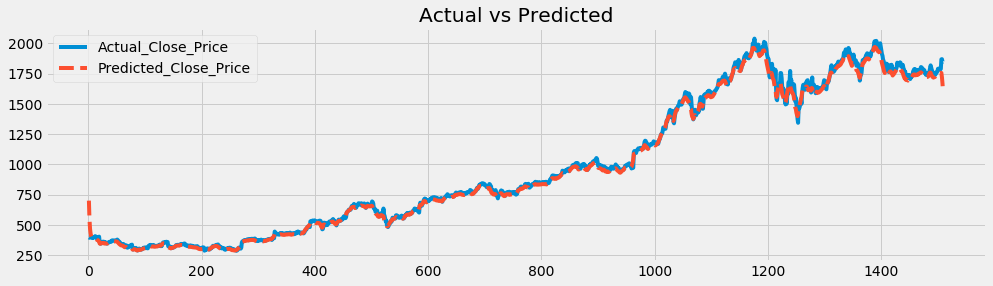

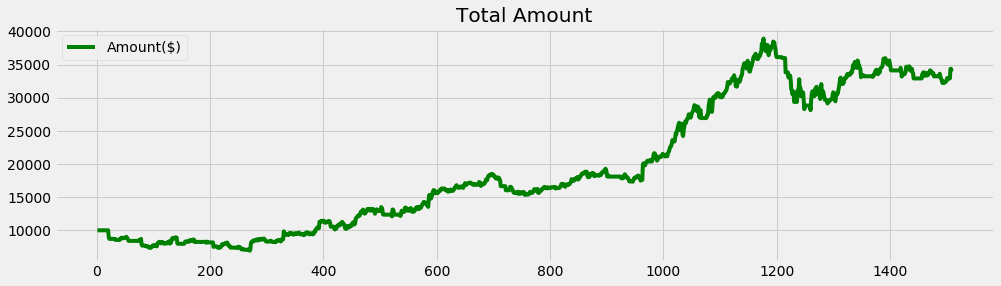

In [234]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-g'], 
                                            title = 'Total Amount')

In [27]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')

Initial_Investment : 10000$
Final Amount: 1824707.0 $
Profit_Percent: 18247.07 %


* Sharpe Ratio

In [28]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()


In [29]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
print(mean_returns,sd)
Market_RF = 0.0464


Sharpe_Ratio = np.sqrt(877)*(mean_returns)/sd
Sharpe_Ratio

0.0035218274171084554 0.011488478368738807


9.078317258627468

# 3.4 Buy & Hold Trading Strategy with Macd

In [30]:
import numpy as np
import pandas as pd
def calculateEMA(period, closeArray, emaArray=[]):
    length = len(closeArray)
    nanCounter = np.count_nonzero(np.isnan(closeArray))
    if not emaArray:
        emaArray.extend(np.tile([np.nan],(nanCounter + period - 1)))
        firstema = np.mean(closeArray[nanCounter:nanCounter + period - 1])    
        emaArray.append(firstema)    
        for i in range(nanCounter+period,length):
            ema=(2*closeArray[i]+(period-1)*emaArray[-1])/(period+1)
            emaArray.append(ema)        
    return np.array(emaArray)
    
def calculateMACD(closeArray,shortPeriod = 12 ,longPeriod = 26 ,signalPeriod =9):
    ema12 = calculateEMA(shortPeriod ,closeArray,[])
    print(ema12)
    ema26 = calculateEMA(longPeriod ,closeArray,[])
    print(ema26)
    diff = ema12-ema26
    
    dea= calculateEMA(signalPeriod ,diff,[])
    macd = 2*(diff-dea)
    return macd,diff,dea

In [31]:
macd, diff, dea=calculateMACD(results['Actual'])

[          nan           nan           nan ... 1804.53043865 1811.0472965
 1816.70770716]
[          nan           nan           nan ... 1786.85618774 1791.30313788
 1795.49105106]


In [32]:
results['Macd'] = macd

In [33]:
# for i in range(1, len(signals)):
#     # If the MACD crosses the signal line upward
#    if signals.long_mavg[i] > df['Y_hat_Kalman'][i] and signals.long_mavg[i - 1] <= df['Y_hat_Kalman'][i - 1]:
#        listLongShort.append("BUY")
#     # The other way around
#    elif signals.short_mavg[i] < df['Y_hat_Kalman'][i] and signals.short_mavg[i - 1] >= df['Y_hat_Kalman'][i - 1]:
#        listLongShort.append("SELL")
#     # Do nothing if not crossed
#    else:
#        listLongShort.append("HOLD")

signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(results)-1):
    if results['Macd'][i] > 0:
        if signal == 0:
            
            action.append('Buy')
            stocks = int(amount / results['Actual'][i])
            balance = int(amount % results['Actual'][i])
            portfolio = stocks * results['Actual'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:',results['Actual'][i] ,'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Hold')
            portfolio = stocks * results['Actual'][i]
            amount = portfolio + balance
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    elif results['Macd'][i] < 0:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * results['Actual'][i]
            
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Hold')
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
    else:
        action.append('Hold')
        print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
        Portfolio.append(round(portfolio,5))
        Amount.append(round(amount,0))
        Stocks.append(stocks)

            
    print('\n')

d Portfolio: 12580.89 Stocks: 7 Balance_init: 1252 total($) 13832.89


Stock: 1819.260009765625 Action: Hold Portfolio: 12734.82 Stocks: 7 Balance_init: 1252 total($) 13986.82


Stock: 1764.77001953125 Action: Hold Portfolio: 12353.39 Stocks: 7 Balance_init: 1252 total($) 13605.39


Stock: 1774.260009765625 Action: Hold Portfolio: 12419.82 Stocks: 7 Balance_init: 1252 total($) 13671.82


Stock: 1783.760009765625 Action: Hold Portfolio: 12486.32 Stocks: 7 Balance_init: 1252 total($) 13738.32


Stock: 1765.699951171875 Action: Hold Portfolio: 12359.9 Stocks: 7 Balance_init: 1252 total($) 13611.9


Stock: 1773.4200439453125 Action: Hold Portfolio: 12413.94 Stocks: 7 Balance_init: 1252 total($) 13665.94


Stock: 1780.75 Action: Hold Portfolio: 12465.25 Stocks: 7 Balance_init: 1252 total($) 13717.25


Stock: 1814.18994140625 Action: Hold Portfolio: 12699.33 Stocks: 7 Balance_init: 1252 total($) 13951.33


Stock: 1813.97998046875 Action: Hold Portfolio: 12697.86 Stocks: 7 Balance_init: 1252 

In [242]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':amzn.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': amzn.Date[1:],
                                 'Action':  action,
                                 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Stocks,Portfolio($),Amount($)
1,396.440002,700.499279,2014-01-03,Hold,0,0.0,10000.0
2,393.630005,546.121895,2014-01-06,Hold,0,0.0,10000.0
3,398.029999,467.370682,2014-01-07,Hold,0,0.0,10000.0
4,401.920013,427.745356,2014-01-08,Hold,0,0.0,10000.0
5,401.010010,407.208938,2014-01-09,Hold,0,0.0,10000.0


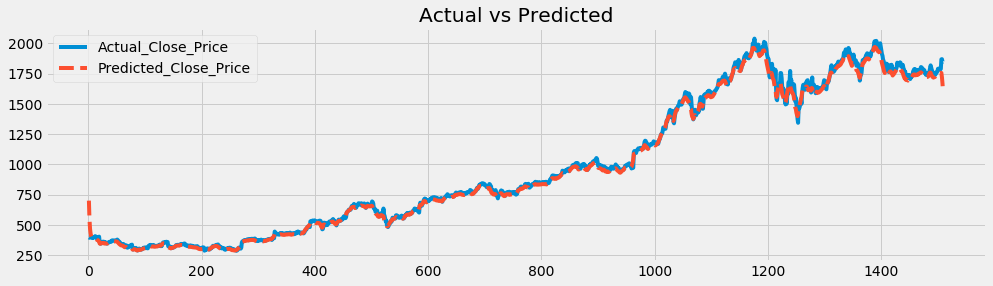

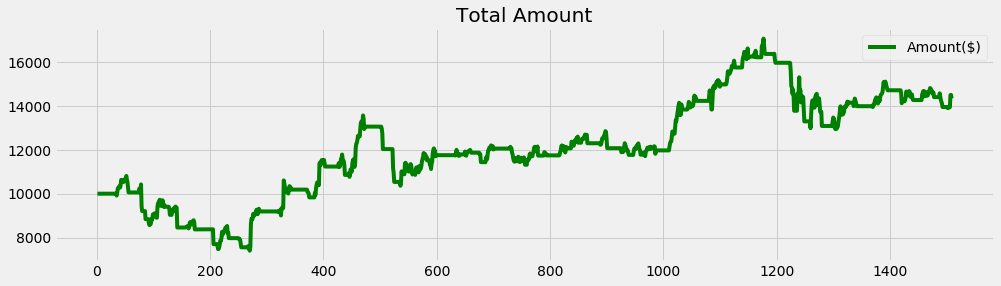

In [243]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-g'], 
                                            title = 'Total Amount')

In [244]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')

Initial_Investment : 10000$
Final Amount: 14348.0 $
Profit_Percent: 143.48000000000002 %


In [245]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()


In [246]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
print(mean_returns,sd)
Market_RF = 0.0464


Sharpe_Ratio = np.sqrt(877)*(mean_returns)/sd
Sharpe_Ratio

0.00031392349846607 0.012252858490704073


0.7587281624487442

# 4. Model evaluaion

* rmse

In [247]:
from sklearn.metrics import mean_squared_error

In [248]:
rms = sqrt(mean_squared_error(Strategy_Result['Actual_Close_Price'], Strategy_Result['Predicted_Close_Price']))

In [249]:
sqrt(rms)

5.400831464207165

* r-square

In [250]:
from sklearn.metrics import r2_score

r2_score(Strategy_Result['Actual_Close_Price'], Strategy_Result['Predicted_Close_Price']) 

0.9973476557276636

# Use Package and smaCross strategy to backTesting

In [251]:
import pandas as pd


def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

In [252]:
from backtesting.test import SMA


In [253]:
from backtesting import Strategy
from backtesting.lib import crossover


class SmaCross(Strategy):
    
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 10
    n2 = 20
    
    def init(self):
        # Precompute two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()

        # Else, if sma1 crosses below sma2, sell it
        elif crossover(self.sma2, self.sma1):
            self.sell()

In [254]:
from backtesting import Backtest

bt = Backtest(df_amzn, SmaCross, cash=10000, commission=.002)
bt.run()

Start                     2014-01-02 00:00:00
End                       2019-12-31 00:00:00
Duration                   2189 days 00:00:00
Exposure [%]                          97.0306
Equity Final [$]                      12531.8
Equity Peak [$]                       19381.5
Return [%]                            25.3181
Buy & Hold Return [%]                 364.316
Max. Drawdown [%]                    -38.7525
Avg. Drawdown [%]                    -7.12193
Max. Drawdown Duration      659 days 00:00:00
Avg. Drawdown Duration       69 days 00:00:00
# Trades                                   78
Win Rate [%]                          39.7436
Best Trade [%]                        22.5932
Worst Trade [%]                      -16.4662
Avg. Trade [%]                       0.482126
Max. Trade Duration         100 days 00:00:00
Avg. Trade Duration          28 days 00:00:00
Expectancy [%]                        5.11059
SQN                                  0.287187
Sharpe Ratio                      

In [255]:
bt.plot()